# Coin Flip Cheaters

This code simulates and considers a strategy for the following game, created by Justin Helps of the youtube channel Primer:
https://primerlearning.org/

The game offers you a series of coin-flipping blobs and asks you to discern whether each blob is flipping a fair coin or a biased coin. A priori, there is a 50% chance that the blob is a cheater, and a 50% chance that the blob is playing it fair. The cheating blobs toss a coin that comes up heads 75% of the time.

You begin the game with 100 coin flips, and you can have each blob flip as many times as you like. At any point, you can guess that the blob is either is or is not a cheater. Labeling a blob correctly grants 15 extra coin flips, while labeling the blob incorrectly results in a 30 flip penalty. The game ends when you run out of flips.

I've written the simulation so that some of these details (chance that the blob is a cheater; how often the biased coins come up heads; the sizes of the bonus and penalty for correctly or incorrectly labeling a blob) can be set arbitrarily.

## My Strategy: p-value testing

I coded an agent to play the game that employs the following strategy:

When given a blob, ask it to flip its coin. Calculate the following two p-values:


Assuming the blob is using a fair coin, calculate the probability of getting a result at least as extreme as that observed. This is equivalent to the right tail of a binomial cumulative distribution function. I call this "fair_p".

Assuming the blob is using a biased coin, calculate the probability of getting a result at least as extreme as that observed. This is equivalent to the left tail of a binomial cumulative distribution function. I call this "cheat_p".

Keep flipping until either of these p-values drops below a specified value of alpha; then, reject its assumption and label the blob with the alternative.

In [1]:
import math
import random
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt

In [2]:
class Flipper:
    # represents a coin-flipping blob
    
    def __init__(self, p_cheat=0.5, p_heads_if_cheat=0.75):
        # p_cheat: the probability that each new blob is a cheater
        # p_heads_if_cheat: the probability that a cheater's coin shows heads
        assert p_cheat > 0 and p_cheat < 1
        assert p_heads_if_cheat > 0 and p_heads_if_cheat < 1
        self.p_cheat = p_cheat
        self.p_heads_if_cheat = p_heads_if_cheat
    
        if random.random() > p_cheat:
            #blob is fair
            self.label = 'fair'
            self.p_heads = 0.5
        else:
            self.label = 'cheater'
            self.p_heads = p_heads_if_cheat
          
        self.num_flips=0
        self.heads=0
        self.tails=0
        
    def flip(self):
        if random.random() < self.p_heads:
            self.heads += 1
        else:
            self.tails += 1
        self.num_flips += 1
    
    def display(self,verbose=False):
        print("Heads: %d" % self.heads)
        print("Tails: %d" % self.tails)
        if verbose:
            LR, fair_p, cheat_p = self.calculate_prob()
            print("Likelihood Ratio: %f" % LR)
            print("Fair p_value = %.3f" % fair_p)
            print("Cheat p_value = %.3f" % cheat_p)
    
    def calculate_prob(self):
        LR = (0.5)**(self.num_flips) / ((self.p_heads_if_cheat)**(self.heads) * (1-self.p_heads_if_cheat)**(self.tails))
        fair_p = 1 - binom.cdf(self.heads-1, self.num_flips, 0.5) #right sided p-value
        cheat_p = binom.cdf(self.heads, self.num_flips, self.p_heads_if_cheat) #left sided p-value
        return LR, fair_p, cheat_p

In [3]:
class Game:
    #objects of this class manage lives, score, and guessing
    
    def __init__(self, correct_bonus=15, incorrect_penalty=30, start_lives=100):
        # correct_bonus: number of extra flips earned by a correct label
        # incorrect_penalty: number of flips lost by an incorrect label
        self.lives = start_lives
        self.score = 0
        self.co_bo = correct_bonus
        self.in_pen = incorrect_penalty
        
        self.conf_matrix = [[0,0], #fair      [true positive, false positive]
                            [0,0]] #cheaters  [false negative, true negative]
        
    def flip(self, flipper, flips=1):
        for i in range(flips):
            flipper.flip()
            self.lives -= 1
    
    def guess(self, flipper, guess, verbose=False):
        if verbose:
            print("Guessing %s" % guess)
        if flipper.label == 'fair':
            if guess == 'fair':
                self.lives += self.co_bo
                self.conf_matrix[0][0] += 1
                self.score += 1
                if verbose:
                    print("Correct: Blob was Fair")
            else:
                self.lives -= self.in_pen
                self.conf_matrix[0][1] += 1
                if verbose:
                    print("Wrong: Blob was Fair")
        if flipper.label == 'cheater':
            if guess == 'cheater':
                self.lives += self.co_bo
                self.conf_matrix[1][1] += 1
                self.score += 1
                if verbose:
                    print("Correct: Blob was a Cheater")
            else:
                self.lives -= self.in_pen
                self.conf_matrix[1][0] += 1
                if verbose:
                    print("Wrong: Blob was a Cheater")

In [4]:
def run_game(alpha=0.15, max_flips_per_blob=10,                        #strategy settings
             correct_bonus=15, incorrect_penalty=30, start_lives=100,  #game settings
             p_cheat=0.5, p_heads_if_cheat=0.75,                       #blob settings
             max_its=1000, verbose=False):
    
    # alpha: the p-value threshold at which to reject one hypothesis in favor of the other
    # max_flips_per_blob: after this number of flips, player will guess based on which p-value is lower
    # correct_bonus: number of extra flips earned by a correct label
    # incorrect_penalty: number of flips lost by an incorrect label
    # p_cheat: the probability that each new blob is a cheater
    # p_heads_if_cheat: the probability that a cheater's coin shows heads
    # max_its: maximum number of turns in a game
    
    game = Game(correct_bonus, incorrect_penalty, start_lives)
    lives, flips_used = [], []
    
    its = 1
    while game.lives > 0 and its <= max_its:
        flipper = Flipper(p_cheat, p_heads_if_cheat)
        guess = 'fair'
        
        while True:
            #continue flipping until either p_value drops below the specified alpha
            game.flip(flipper)
            _, fair_p, cheat_p = flipper.calculate_prob()
            if fair_p < alpha:
                guess = 'cheater'
                break
            if cheat_p < alpha:
                break
            if flipper.num_flips >= max_flips_per_blob:
                if fair_p < cheat_p:
                    guess = 'cheater'
                break
                
        if verbose:
            flipper.display()
            
        game.guess(flipper, guess, verbose)
        flips_used.append(flipper.num_flips)
        lives.append(game.lives)
        
        if verbose:
            print("Lives: %d" % game.lives)
            print("Score: %d" % game.score)
            print()
        else:
            print("Turn %d\t Lives: %d\t Score: %d       " % (its, game.lives, game.score), end='\r')
        
        its += 1
        
    print()
    return game.score, game.conf_matrix, lives, flips_used

def print_game_details(game_output):
    score, cm, lives, flips_used = game_output
    if lives[-1] > 0:
        print("Maximum iterations reached.")
    else:
        print("Ran out of lives.")
    print("Final score: %d" % score)
    print("Average number of flips used per blob: %.2f" % (sum(flips_used)/len(flips_used)))
    print("Confusion matrix:\n", cm[0], '\n', cm[1])
    print("False positive rate: %.3f" % (cm[0][1]/(cm[0][1]+cm[1][1])))
    print("False negative rate: %.3f" % (cm[1][0]/(cm[1][0]+cm[0][0])))
    plt.plot(range(len(lives)),lives)
    plt.xlabel("Turn")
    plt.ylabel("Lives")
    plt.show()

Turn 5000	 Lives: 9615	 Score: 3919        
Maximum iterations reached.
Final score: 3919
Average number of flips used per blob: 5.35
Confusion matrix:
 [1905, 583] 
 [498, 2014]
False positive rate: 0.224
False negative rate: 0.207


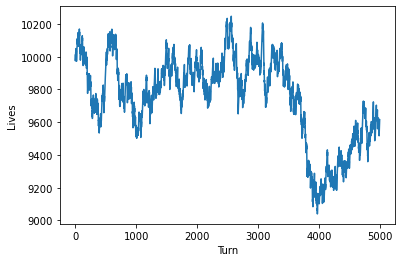

In [5]:
out = run_game(alpha=0.15,max_its=5000, start_lives=10000,max_flips_per_blob=100)
print_game_details(out)

## A winning strategy
Let 
- r = error rate
- b = correct_bonus
- p = incorrect_penalty
- f = average # of flips per blob

Then, a winning strategy must satisfy:
\begin{align*}
    (1-r)b - rp - f &> 0 \\
    b-rb-rp-f &> 0 \\
    b-r(b+p)-f &> 0 \\
    b-f &> r(b+p) \\
    \frac{b-f}{b+p} &> r
\end{align*}

Remark: both $f$ and $r$ depend on our choice of alpha. Let's use a simulation to model these relationships.

In [6]:
def expected_value(error_rate, avg_flips, correct_bonus=15, incorrect_penalty=30):
    r, f, b, p = error_rate, avg_flips, correct_bonus, incorrect_penalty
    return (1-r)*b - r*p - f

In [7]:
alphas = np.linspace(0.15,0.20,6)
error_rates = []
end_lives = []
avg_flips = []
EVs = []
cb, ip = 15, 30
for alpha in alphas:
    alpha = round(alpha,2)
    print("alpha=%.2f:" % alpha)
    _,cm,lives,flips = run_game(alpha=alpha,max_its=10000,start_lives=10000,max_flips_per_blob=100, correct_bonus=cb, incorrect_penalty=ip)
    
    r = (cm[0][1] + cm[1][0])/(np.sum(cm))
    error_rates.append(r)
    
    end_lives.append(lives[-1])
    
    f = sum(flips)/len(flips)
    avg_flips.append(f)
    
    EV = expected_value(r, f, correct_bonus=cb, incorrect_penalty=ip)
    EVs.append(EV)
    print("Expected lives gained/lost per blob: %+.3f" % EV)

alpha=0.15:
Turn 10000	 Lives: 8470	 Score: 7815       
Expected lives gained/lost per blob: -0.153
alpha=0.16:
Turn 10000	 Lives: 11628	 Score: 7749       
Expected lives gained/lost per blob: +0.163
alpha=0.17:
Turn 10000	 Lives: 8730	 Score: 7643       
Expected lives gained/lost per blob: -0.127
alpha=0.18:
Turn 10000	 Lives: 4084	 Score: 7519       
Expected lives gained/lost per blob: -0.592
alpha=0.19:
Turn 10000	 Lives: 5010	 Score: 7475       
Expected lives gained/lost per blob: -0.499
alpha=0.20:
Turn 10000	 Lives: 8397	 Score: 7543       
Expected lives gained/lost per blob: -0.160


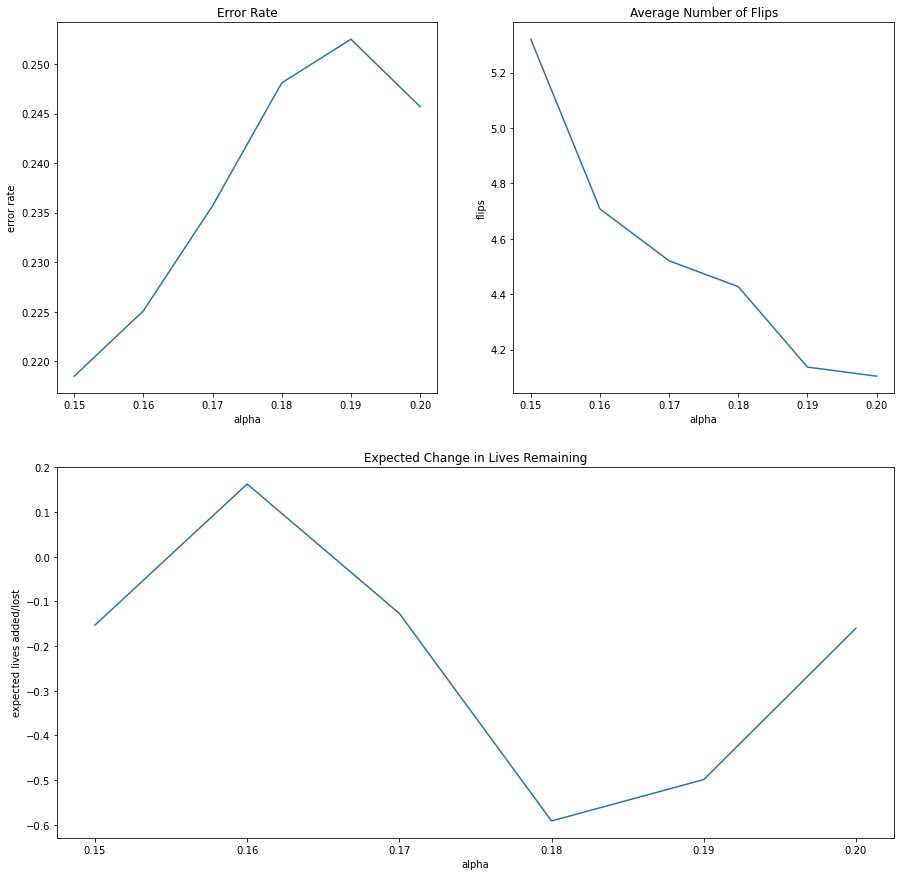

In [8]:
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(221)
ax1.plot(alphas[:len(error_rates)],error_rates)
ax1.set_xlabel("alpha")
ax1.set_ylabel("error rate")
ax1.set_title("Error Rate")

ax2 = fig.add_subplot(222)
ax2.plot(alphas[:len(avg_flips)],avg_flips)
ax2.set_xlabel("alpha")
ax2.set_ylabel("flips")
ax2.set_title("Average Number of Flips")

ax3 = fig.add_subplot(212)
ax3.plot(alphas[:len(EVs)],EVs)
ax3.set_xlabel("alpha")
ax3.set_ylabel("expected lives added/lost")
ax3.set_title("Expected Change in Lives Remaining")

plt.show()